In [24]:
import numpy as np
import pandas as pd
import sys
import json
import os
import copy
import matplotlib.pyplot as plt
import scipy
import multiprocessing
import h5py
import corner
import dynesty
from tqdm import tqdm

Import saved NS run:

In [25]:
# run to import
dsampler = dynesty.DynamicNestedSampler.restore('./dynesty_saves/kosice_unrestricted_heights.save')  # CHANGE
results = dsampler.results
samples = results.samples
ndim = len(samples.T)
results.summary()

Summary
niter: 44859
ncall: 1250166
eff(%):  3.424
logz: -125.028 +/-  0.143


In [26]:
samples[-1]

array([8.80494154e+04, 8.91016401e+01, 8.72204793e+01, 1.67137488e-06,
       1.46198610e-06, 1.09135030e-03, 8.66213755e+02, 3.52050942e+03,
       1.61834652e+03, 3.93420940e+04, 3.37152748e+04])

Generate marginalized distributions of derived parameters from NS -- total initial mass, mass pcts and dynamic pressure of fragments, peak dynamic pressure, and mass remaining at peak dynamic pressure

In [27]:
sys.path.append('../../')

import source.WesternMeteorPyLib.wmpl.MetSim.MetSim as metsim
import source.WesternMeteorPyLib.wmpl.MetSim.FitSim as fitsim
import source.WesternMeteorPyLib.wmpl.MetSim.GUI as gui
import source.WesternMeteorPyLib.wmpl.MetSim.MetSimErosion as erosion
import source.WesternMeteorPyLib.wmpl.Utils.Pickling as pickling

class MetSimObj():
    def __init__(self, traj_path, const_json_file, fixed_frag_indices, free_frag_indices, er_frag_indices):
        # Init an axis for the electron line density
        # self.electronDensityPlot = self.magnitudePlot.canvas.axes.twiny()
        self.electron_density_plot_show = False
        ### Wake parameters ###
        self.wake_on = False
        self.wake_show_mass_bins = False
        self.wake_ht_current_index = 0
        self.current_wake_container = None
        # if self.wake_heights is not None:
        #     self.wake_plot_ht, self.current_wake_container = self.wake_heights[self.wake_ht_current_index]
        # else:
        #     self.wake_plot_ht = self.traj.rbeg_ele # m
        self.wake_normalization_method = 'area'
        self.wake_align_method = 'none'
        self.magnitudePlotWakeLines = None
        self.magnitudePlotWakeLineLabels = None
        self.velocityPlotWakeLines = None
        self.lagPlotWakeLines = None
        self.usg_data, self.traj = gui.loadUSGInputFile(*os.path.split(traj_path))
        self.dir_path = os.path.dirname(traj_path)
        # Disable different density after erosion change
        self.erosion_different_rho = False
        # Disable different ablation coeff after erosion change
        self.erosion_different_sigma = False
        # Disable different erosion coeff after disruption at the beginning
        self.disruption_different_erosion_coeff = False
        # Fragmentation object
        self.fragmentation = None
        self.simulation_results = None
        self.const_prev = None
        self.simulation_results_prev = None
        self.const = erosion.Constants()  # initialize this, these will be replaced later
        self.const.P_0m = self.usg_data.P_0m_bolo
        # If a JSON file with constant was given, load them instead of initing from scratch
        if const_json_file is not None:
            # Load the constants from the JSON files
            self.const, const_json = gui.loadConstants(const_json_file)
            # Init the fragmentation container for the GUI
            if len(self.const.fragmentation_entries):
                self.fragmentation = gui.FragmentationContainer(self, \
                    os.path.join(self.dir_path, self.const.fragmentation_file_name))
                self.fragmentation.fragmentation_entries = self.const.fragmentation_entries
                # Overwrite the existing fragmentatinon file
                # self.fragmentation.writeFragmentationFile()
            # Check if the disruption erosion coefficient is different than the main erosion coeff
            if const_json['disruption_erosion_coeff'] != const_json['erosion_coeff']:
                self.disruption_different_erosion_coeff = True
            # Check if the density is changed after Hchange
            if 'erosion_rho_change' in const_json:
                if const_json['erosion_rho_change'] != const_json['rho']:
                    self.erosion_different_rho = True
            # Check if the ablation coeff is changed after Hchange
            if 'erosion_sigma_change' in const_json:
                if const_json['erosion_sigma_change'] != const_json['sigma']:
                    self.erosion_different_sigma = True
        else:
            raise('no json file!')

        ### Calculate atmosphere density coeffs (down to the bottom observed height, limit to 15 km) ###

        # Determine the height range for fitting the density
        self.dens_fit_ht_beg = self.const.h_init
        self.dens_fit_ht_end = self.traj.rend_ele - 5000
        if self.dens_fit_ht_end < 14000:
            self.dens_fit_ht_end = 14000

        # Fit the polynomail describing the density
        dens_co = gui.MetSimGUI.fitAtmosphereDensity(self, self.dens_fit_ht_beg, self.dens_fit_ht_end)
        self.const.dens_co = dens_co

        # get global parameters from json file, everything other than params marked "free" are fixed
        dt = const_json.get('dt')
        P_0m = const_json.get('P_0m')
        h_init = const_json.get('h_init')
        m_kill = const_json.get('m_kill')
        v_kill = const_json.get('v_kill')
        h_kill = const_json.get('h_kill')
        len_kill = const_json.get('len_kill') 
        rho = const_json.get('rho')  # free
        rho_grain = const_json.get('rho_grain')  # free
        m_init = const_json.get('m_init')  # free
        sigma = const_json.get('sigma')  # free
        v_init = const_json.get('v_init')
        shape_factor = const_json.get('shape_factor')
        gamma = const_json.get('gamma')
        zenith_angle = const_json.get('zenith_angle')
        lum_eff = const_json.get('lum_eff')
        lum_eff_type = const_json.get('lum_eff_type')
        erosion_height_start = const_json.get('erosion_height_start')
        erosion_bins_per_10mass = const_json.get('erosion_bins_per_10mass')
        erosion_coeff = const_json.get('erosion_coeff')
        erosion_height_change = const_json.get('erosion_height_change')
        erosion_coeff_change = const_json.get('erosion_coeff_change')
        erosion_mass_index = const_json.get('erosion_mass_index')
        erosion_mass_min = const_json.get('erosion_mass_min')
        erosion_mass_max = const_json.get('erosion_mass_max')
        erosion_rho_change = const_json.get('rho')
        erosion_sigma_change = const_json.get('sigma')
        compressive_strength = const_json.get('compressive_strength')
        disruption_erosion_coeff = const_json.get('erosion_coeff')
        disruption_mass_grain_ratio = const_json.get('disruption_mass_grain_ratio')
        disruption_mass_index = const_json.get('disruption_mass_index')
        disruption_mass_min_ratio = const_json.get('disruption_mass_min_ratio')
        disruption_mass_max_ratio = const_json.get('disruption_mass_max_ratio')

        # get fragmentation parameters from json file
        # type, height, number, gamma, mass index are fixed, 
        # mass, ablation coefficient, erosion coefficient, grain min, grain max are not fixed
        num_frags = len(const_json.get('fragmentation_entries'))
        # fixed
        frag_types = []
        frag_numbers = []
        frag_ab_coeffs = []
        frag_gammas = []
        frag_mis = []
        # free
        frag_masses = []
        frag_er_coeffs = []
        frag_grain_mins = []
        frag_grain_maxs = []
        frag_heights = []

        # set free and fixed params
        #### CHANGE THESE LINES TO TEST DIFFERENT COMBINATIONS OF FREE PARAMETERS
        self.fixed_frag_indices = fixed_frag_indices
        self.free_frag_indices = free_frag_indices
        self.er_frag_indices = er_frag_indices
        # set up masks for free and fixed indices
        # free
        free_frag_mask = np.zeros(num_frags, bool)
        free_frag_mask[free_frag_indices] = True  # only free frags
        # fixed
        fixed_frag_mask = np.ones(num_frags, bool)
        fixed_frag_mask[free_frag_indices] = False  # everything EXCEPT free frags (i.e. fixed frags)
        # erosion
        er_frag_mask = np.zeros(num_frags, bool)
        er_frag_mask[er_frag_indices] = True  # only frags that have erosion coefficients (i.e. all free fragments excluding dust)
        
        for i, frag in enumerate(const_json.get('fragmentation_entries')):
            ### If sigma, gamma and erosiion coefficient are none, convert to whatever the default value is 
            # fixed
            frag_types.append(frag['frag_type'])
            frag_numbers.append(frag['number'])
            if frag['gamma'] == None:
                frag_gammas.append(gamma)
            else:
                frag_gammas.append(frag['gamma'])
            frag_mis.append(frag['mass_index'])
            if frag['sigma'] == None:
                frag_ab_coeffs.append(sigma) 
            else:
                frag_ab_coeffs.append(frag['sigma'])
            # free
            frag_masses.append(frag['mass_percent'])
            if frag['erosion_coeff'] == None:  # this means that the fragment is dust
                frag_er_coeffs.append(0.)  # erosion coefficient of zero
            else:
                frag_er_coeffs.append(frag['erosion_coeff'])
            frag_grain_mins.append(frag['grain_mass_min'])
            frag_grain_maxs.append(frag['grain_mass_max'])
            frag_heights.append(frag['height'])

        # fixed_frag_mask = np.argsort(fixed_frag_mask)
        # assign free fixed parameters to object
        self.free_params = [m_init, 
                            list(np.array(frag_masses)[free_frag_mask]), 
                            list(np.array(frag_er_coeffs)[er_frag_mask]),  # use er frag mask for this one! 
                            list(np.array(frag_grain_mins)[free_frag_mask]), 
                            list(np.array(frag_grain_maxs)[free_frag_mask]),
                            list(np.array(frag_heights)[free_frag_mask])  # heights
                           ]
        self.fixed_params = [dt, P_0m, h_init, m_kill, v_kill, h_kill, len_kill, rho, rho_grain, sigma, 
                             v_init, shape_factor, 
                            gamma, zenith_angle, lum_eff, lum_eff_type, erosion_height_start, 
                            erosion_bins_per_10mass, erosion_coeff, erosion_height_change, 
                            erosion_coeff_change, erosion_mass_index, erosion_mass_min, erosion_mass_max, 
                            erosion_rho_change, erosion_sigma_change, compressive_strength, 
                            disruption_erosion_coeff, disruption_mass_grain_ratio, disruption_mass_index, 
                            disruption_mass_min_ratio, disruption_mass_max_ratio, 
                            frag_types, frag_numbers, 
                            frag_ab_coeffs, frag_gammas, frag_mis,
                            list(np.array(frag_masses)[fixed_frag_mask]), 
                            list(np.array(frag_er_coeffs)[~er_frag_mask]),  # and inverse of er frag mask 
                            list(np.array(frag_grain_mins)[fixed_frag_mask]), 
                            list(np.array(frag_grain_maxs)[fixed_frag_mask]),
                            list(np.array(frag_heights)[fixed_frag_mask])
                            ]
        
        # load all the global parameters into the object
        consts = dt, P_0m, h_init, m_kill, v_kill, h_kill, len_kill, rho, rho_grain, m_init, sigma, v_init, shape_factor, gamma, zenith_angle, lum_eff, lum_eff_type, erosion_height_start, erosion_bins_per_10mass, erosion_coeff, erosion_height_change, erosion_coeff_change, erosion_mass_index, erosion_mass_min, erosion_mass_max, erosion_rho_change, erosion_sigma_change, compressive_strength, disruption_erosion_coeff, disruption_mass_grain_ratio, disruption_mass_index, disruption_mass_min_ratio, disruption_mass_max_ratio
        self.loadGlobalParameters(consts)

        # get all parameters
        self.all_params = (self.free_params, self.fixed_params)
        
        # self.initializeSimulation(all_params)
        # self.initializeSimulation(const_json)
    
    def loadGlobalParameters(self, consts):
            """
            Loads the global parameters (constants) into the object
            """
            dt, P_0m, h_init, m_kill, v_kill, h_kill, len_kill, rho, rho_grain, m_init, sigma, v_init, shape_factor, gamma, zenith_angle, lum_eff, lum_eff_type, erosion_height_start, erosion_bins_per_10mass, erosion_coeff, erosion_height_change, erosion_coeff_change, erosion_mass_index, erosion_mass_min, erosion_mass_max, erosion_rho_change, erosion_sigma_change, compressive_strength, disruption_erosion_coeff, disruption_mass_grain_ratio, disruption_mass_index, disruption_mass_min_ratio, disruption_mass_max_ratio = consts
            # load all the non-fragmentation parameters into the object
            # 33 parameters
            self.const.dt = dt
            self.const.P_0m = P_0m
            self.const.h_init = h_init
            self.const.m_kill = m_kill
            self.const.v_kill = v_kill
            self.const.h_kill = h_kill
            self.const.len_kill = len_kill
            self.const.rho = rho
            self.const.rho_grain = rho_grain
            self.const.m_init = m_init
            self.const.sigma = sigma
            self.const.v_init = v_init
            self.const.shape_factor = shape_factor
            self.const.gamma = gamma
            self.const.zenith_angle = zenith_angle
            self.const.lum_eff = lum_eff
            self.const.lum_eff_type = lum_eff_type
            self.const.erosion_height_start = erosion_height_start
            self.const.erosion_bins_per_10mass = erosion_bins_per_10mass
            self.const.erosion_coeff = erosion_coeff
            self.const.erosion_height_change = erosion_height_change
            self.const.erosion_coeff_change = erosion_coeff_change
            self.const.erosion_mass_index = erosion_mass_index
            self.const.erosion_mass_min = erosion_mass_min
            self.const.erosion_mass_max = erosion_mass_max
            self.const.erosion_rho_change = erosion_rho_change
            self.const.erosion_sigma_change = erosion_sigma_change
            self.const.compressive_strength = compressive_strength
            self.const.disruption_erosion_coeff = disruption_erosion_coeff
            self.const.disruption_mass_grain_ratio = disruption_mass_grain_ratio
            self.const.disruption_mass_index = disruption_mass_index
            self.const.disruption_mass_min_ratio = disruption_mass_min_ratio
            self.const.disruption_mass_max_ratio = disruption_mass_max_ratio

    def initializeSimulation(self, all_params):
            """ Run the simulation and show the results. """
            # If the fragmentation is turned on and no fragmentation data is given, notify the user
            # if self.const.fragmentation_on and (self.fragmentation is None):
            #     frag_error_message = QMessageBox(QMessageBox.Critical, "Fragmentation file error", \
            #         "Fragmentation is enabled but no fragmentation file is set.")
            #     frag_error_message.setInformativeText("Either load an existing fragmentation file or create a new one.")
            #     frag_error_message.exec_()
            #     return None   

            # unpack all params
            free_params, fixed_params = all_params
            # unpack again
            #### CHANGE THESE NEXT TWO LINES TO TEST DIFFERENT COMBINATIONS OF FREE PARAMETERS
            m_init, frag_masses_free, frag_er_coeffs_free, frag_grain_mins_free, frag_grain_maxs_free, frag_heights_free = free_params 
            dt, P_0m, h_init, m_kill, v_kill, h_kill, len_kill, rho, rho_grain, sigma, v_init, shape_factor, gamma, zenith_angle, lum_eff, lum_eff_type, erosion_height_start, erosion_bins_per_10mass, erosion_coeff, erosion_height_change, erosion_coeff_change, erosion_mass_index, erosion_mass_min, erosion_mass_max, erosion_rho_change, erosion_sigma_change, compressive_strength, disruption_erosion_coeff, disruption_mass_grain_ratio, disruption_mass_index, disruption_mass_min_ratio, disruption_mass_max_ratio, frag_types, frag_numbers, frag_ab_coeffs, frag_gammas, frag_mis, frag_masses_fixed, frag_er_coeffs_fixed, frag_grain_mins_fixed, frag_grain_maxs_fixed, frag_heights_fixed = fixed_params
            # load all the global parameters into the object
            consts = dt, P_0m, h_init, m_kill, v_kill, h_kill, len_kill, rho, rho_grain, m_init, sigma, v_init, shape_factor, gamma, zenith_angle, lum_eff, lum_eff_type, erosion_height_start, erosion_bins_per_10mass, erosion_coeff, erosion_height_change, erosion_coeff_change, erosion_mass_index, erosion_mass_min, erosion_mass_max, erosion_rho_change, erosion_sigma_change, compressive_strength, disruption_erosion_coeff, disruption_mass_grain_ratio, disruption_mass_index, disruption_mass_min_ratio, disruption_mass_max_ratio
            self.loadGlobalParameters(consts)
            # combine free fixed fragmentation parameters
            frag_order = np.argsort(self.fixed_frag_indices + self.free_frag_indices)
            frag_masses = np.concatenate((frag_masses_fixed, frag_masses_free))[frag_order]
            frag_er_coeffs = np.zeros(len(frag_masses))  # number of fragments
            frag_er_coeffs[self.er_frag_indices] = frag_er_coeffs_free  # set all erosion fragments to their values, everything else is zero
            frag_grain_mins = np.concatenate((frag_grain_mins_fixed, frag_grain_mins_free))[frag_order]
            frag_grain_maxs = np.concatenate((frag_grain_maxs_fixed, frag_grain_maxs_free))[frag_order]
            frag_heights = np.concatenate((frag_heights_fixed, frag_heights_free))[frag_order]

            # print(frag_order, np.concatenate((frag_masses_fixed, frag_masses_free)), frag_masses)
            
            # Load fragmentation entries
            self.fragmentation_entries = []
            for i in range(0, len(frag_masses)):  # pick any frag entry to iterate over
                frag_entry = gui.FragmentationEntry(frag_types[i], frag_heights[i], frag_numbers[i], frag_masses[i], 
                                                    frag_ab_coeffs[i], frag_gammas[i], frag_er_coeffs[i], frag_grain_mins[i], frag_grain_maxs[i], frag_mis[i])
                self.fragmentation_entries.append(frag_entry)
            # set the fragmentation entries to constants
            self.const.fragmentation_entries = self.fragmentation_entries
    
            # Sort entries by height
            self.fragmentation.sortByHeight()

            # Reset the status of all fragmentations
            self.fragmentation.resetAll()
        
            # fragmentation
            self.const.fragmentation_on = True

            # print(self.const.fragmentation_on)
    
            # Run the simulation
            frag_main, results_list, wake_results = erosion.runSimulation(self.const, compute_wake=self.wake_on)
            # print(results_list)

            # Store simulation results
            self.simulation_results = gui.SimulationResults(self.const, frag_main, results_list, wake_results)       

In [28]:
null=None
class MetSimObjCSV():
    def __init__(self, traj_path, const_json_file, lc_path, fixed_frag_indices, free_frag_indices, er_frag_indices):
        # Init an axis for the electron line density
        # self.electronDensityPlot = self.magnitudePlot.canvas.axes.twiny()
        self.electron_density_plot_show = False
        ### Wake parameters ###
        self.wake_on = False
        self.wake_show_mass_bins = False
        self.wake_ht_current_index = 0
        self.current_wake_container = None
        # if self.wake_heights is not None:
        #     self.wake_plot_ht, self.current_wake_container = self.wake_heights[self.wake_ht_current_index]
        # else:
        #     self.wake_plot_ht = self.traj.rbeg_ele # m
        self.wake_normalization_method = 'area'
        self.wake_align_method = 'none'
        self.magnitudePlotWakeLines = None
        self.magnitudePlotWakeLineLabels = None
        self.velocityPlotWakeLines = None
        self.lagPlotWakeLines = None
        self.traj = pickling.loadPickle(*os.path.split(traj_path))
        # self.usg_data, self.traj = gui.loadUSGInputFile(*os.path.split(traj_path))
        self.dir_path = os.path.dirname(traj_path)
        # Disable different density after erosion change
        self.erosion_different_rho = False
        # Disable different ablation coeff after erosion change
        self.erosion_different_sigma = False
        # Disable different erosion coeff after disruption at the beginning
        self.disruption_different_erosion_coeff = False
        # Fragmentation object
        self.fragmentation = None
        self.simulation_results = None
        self.const_prev = None
        self.simulation_results_prev = None
        self.const = erosion.Constants()  # initialize this, these will be replaced later
        if lc_path is not None:
            self.lc_data = gui.LightCurveContainer(*os.path.split(os.path.abspath(lc_path)))
        # if self.usg_data is not None:
        #     self.const.P_0m = self.usg_data.P_0m_bolo
        # If a JSON file with constant was given, load them instead of initing from scratch
        if const_json_file is not None:
            # Load the constants from the JSON files
            self.const, const_json = gui.loadConstants(const_json_file)
            # Init the fragmentation container for the GUI
            if len(self.const.fragmentation_entries):
                self.fragmentation = gui.FragmentationContainer(self, \
                    os.path.join(self.dir_path, self.const.fragmentation_file_name))
                self.fragmentation.fragmentation_entries = self.const.fragmentation_entries
                # Overwrite the existing fragmentatinon file
                # self.fragmentation.writeFragmentationFile()
            # Check if the disruption erosion coefficient is different than the main erosion coeff
            if const_json['disruption_erosion_coeff'] != const_json['erosion_coeff']:
                self.disruption_different_erosion_coeff = True
            # Check if the density is changed after Hchange
            if 'erosion_rho_change' in const_json:
                if const_json['erosion_rho_change'] != const_json['rho']:
                    self.erosion_different_rho = True
            # Check if the ablation coeff is changed after Hchange
            if 'erosion_sigma_change' in const_json:
                if const_json['erosion_sigma_change'] != const_json['sigma']:
                    self.erosion_different_sigma = True
        else:
            raise('no json file!')

        ### Calculate atmosphere density coeffs (down to the bottom observed height, limit to 15 km) ###

        # Determine the height range for fitting the density
        self.dens_fit_ht_beg = self.const.h_init
        self.dens_fit_ht_end = self.traj.rend_ele - 5000
        if self.dens_fit_ht_end < 14000:
            self.dens_fit_ht_end = 14000

        # Fit the polynomail describing the density
        dens_co = gui.MetSimGUI.fitAtmosphereDensity(self, self.dens_fit_ht_beg, self.dens_fit_ht_end)
        self.const.dens_co = dens_co

        # get global parameters from json file, everything other than params marked "free" are fixed
        dt = const_json.get('dt')
        P_0m = const_json.get('P_0m')
        h_init = const_json.get('h_init')
        m_kill = const_json.get('m_kill')
        v_kill = const_json.get('v_kill')
        h_kill = const_json.get('h_kill')
        len_kill = const_json.get('len_kill') 
        rho = const_json.get('rho')  # free
        rho_grain = const_json.get('rho_grain')  # free
        m_init = const_json.get('m_init')  # free
        sigma = const_json.get('sigma')  # free
        v_init = const_json.get('v_init')
        shape_factor = const_json.get('shape_factor')
        gamma = const_json.get('gamma')
        zenith_angle = const_json.get('zenith_angle')
        lum_eff = const_json.get('lum_eff')
        lum_eff_type = const_json.get('lum_eff_type')
        erosion_height_start = const_json.get('erosion_height_start')
        erosion_bins_per_10mass = const_json.get('erosion_bins_per_10mass')
        erosion_coeff = const_json.get('erosion_coeff')
        erosion_height_change = const_json.get('erosion_height_change')
        erosion_coeff_change = const_json.get('erosion_coeff_change')
        erosion_mass_index = const_json.get('erosion_mass_index')
        erosion_mass_min = const_json.get('erosion_mass_min')
        erosion_mass_max = const_json.get('erosion_mass_max')
        erosion_rho_change = const_json.get('rho')
        erosion_sigma_change = const_json.get('sigma')
        compressive_strength = const_json.get('compressive_strength')
        disruption_erosion_coeff = const_json.get('erosion_coeff')
        disruption_mass_grain_ratio = const_json.get('disruption_mass_grain_ratio')
        disruption_mass_index = const_json.get('disruption_mass_index')
        disruption_mass_min_ratio = const_json.get('disruption_mass_min_ratio')
        disruption_mass_max_ratio = const_json.get('disruption_mass_max_ratio')

        # get fragmentation parameters from json file
        # type, height, number, gamma, mass index are fixed, 
        # mass, ablation coefficient, erosion coefficient, grain min, grain max are not fixed
        num_frags = len(const_json.get('fragmentation_entries'))
        # fixed
        frag_types = []
        frag_numbers = []
        frag_ab_coeffs = []
        frag_gammas = []
        frag_mis = []
        # free
        frag_masses = []
        frag_er_coeffs = []
        frag_grain_mins = []
        frag_grain_maxs = []
        frag_heights = []

        # set free and fixed params
        #### CHANGE THESE LINES TO TEST DIFFERENT COMBINATIONS OF FREE PARAMETERS
        self.fixed_frag_indices = fixed_frag_indices
        self.free_frag_indices = free_frag_indices
        self.er_frag_indices = er_frag_indices
        # set up masks for free and fixed indices
        # free
        free_frag_mask = np.zeros(num_frags, bool)
        free_frag_mask[free_frag_indices] = True  # only free frags
        # fixed
        fixed_frag_mask = np.ones(num_frags, bool)
        fixed_frag_mask[free_frag_indices] = False  # everything EXCEPT free frags (i.e. fixed frags)
        # erosion
        er_frag_mask = np.zeros(num_frags, bool)
        er_frag_mask[er_frag_indices] = True  # only frags that have erosion coefficients (i.e. all free fragments excluding dust)
        
        for i, frag in enumerate(const_json.get('fragmentation_entries')):
            ### If sigma, gamma and erosiion coefficient are none, convert to whatever the default value is 
            # fixed
            frag_types.append(frag['frag_type'])
            frag_numbers.append(frag['number'])
            if frag['gamma'] == None:
                frag_gammas.append(gamma)
            else:
                frag_gammas.append(frag['gamma'])
            frag_mis.append(frag['mass_index'])
            if frag['sigma'] == None:
                frag_ab_coeffs.append(sigma) 
            else:
                frag_ab_coeffs.append(frag['sigma'])
            # free
            frag_masses.append(frag['mass_percent'])
            if frag['erosion_coeff'] == None:  # this means that the fragment is dust or a single-body fragment
                frag_er_coeffs.append(0.)  # erosion coefficient of zero
            else:
                frag_er_coeffs.append(frag['erosion_coeff'])
            if frag['grain_mass_min'] == None:  # this means the fragment is a single-body fragment
                frag_grain_mins.append(null)  # append null
            else:
                frag_grain_mins.append(frag['grain_mass_min'])
            if frag['grain_mass_max'] == None:  # this means the fragment is a single-body fragment
                frag_grain_maxs.append(null)  # append null
            else:
                frag_grain_maxs.append(frag['grain_mass_max'])
            frag_heights.append(frag['height'])
        # print(frag_grain_mins, frag_grain_maxs)
        # fixed_frag_mask = np.argsort(fixed_frag_mask)
        # assign free fixed parameters to object
        self.free_params = [m_init, 
                            list(np.array(frag_masses)[free_frag_mask]), 
                            list(np.array(frag_er_coeffs)[er_frag_mask]),  # use er frag mask for this one! 
                            list(np.array(frag_grain_mins)[er_frag_mask]), 
                            list(np.array(frag_grain_maxs)[er_frag_mask]),
                            list(np.array(frag_heights)[free_frag_mask])  # heights
                           ]
        self.fixed_params = [dt, P_0m, h_init, m_kill, v_kill, h_kill, len_kill, rho, rho_grain, sigma, 
                             v_init, shape_factor, 
                            gamma, zenith_angle, lum_eff, lum_eff_type, erosion_height_start, 
                            erosion_bins_per_10mass, erosion_coeff, erosion_height_change, 
                            erosion_coeff_change, erosion_mass_index, erosion_mass_min, erosion_mass_max, 
                            erosion_rho_change, erosion_sigma_change, compressive_strength, 
                            disruption_erosion_coeff, disruption_mass_grain_ratio, disruption_mass_index, 
                            disruption_mass_min_ratio, disruption_mass_max_ratio, 
                            frag_types, frag_numbers, 
                            frag_ab_coeffs, frag_gammas, frag_mis,
                            list(np.array(frag_masses)[fixed_frag_mask]), 
                            list(np.array(frag_er_coeffs)[~er_frag_mask]),  # and inverse of er frag mask 
                            list(np.array(frag_grain_mins)[~er_frag_mask]), 
                            list(np.array(frag_grain_maxs)[~er_frag_mask]),
                            list(np.array(frag_heights)[fixed_frag_mask])
                            ]
        
        # load all the global parameters into the object
        consts = dt, P_0m, h_init, m_kill, v_kill, h_kill, len_kill, rho, rho_grain, m_init, sigma, v_init, shape_factor, gamma, zenith_angle, lum_eff, lum_eff_type, erosion_height_start, erosion_bins_per_10mass, erosion_coeff, erosion_height_change, erosion_coeff_change, erosion_mass_index, erosion_mass_min, erosion_mass_max, erosion_rho_change, erosion_sigma_change, compressive_strength, disruption_erosion_coeff, disruption_mass_grain_ratio, disruption_mass_index, disruption_mass_min_ratio, disruption_mass_max_ratio
        self.loadGlobalParameters(consts)

        # get all parameters
        self.all_params = (self.free_params, self.fixed_params)
        
        # self.initializeSimulation(all_params)
        # self.initializeSimulation(const_json)
    
    def loadGlobalParameters(self, consts):
            """
            Loads the global parameters (constants) into the object
            """
            dt, P_0m, h_init, m_kill, v_kill, h_kill, len_kill, rho, rho_grain, m_init, sigma, v_init, shape_factor, gamma, zenith_angle, lum_eff, lum_eff_type, erosion_height_start, erosion_bins_per_10mass, erosion_coeff, erosion_height_change, erosion_coeff_change, erosion_mass_index, erosion_mass_min, erosion_mass_max, erosion_rho_change, erosion_sigma_change, compressive_strength, disruption_erosion_coeff, disruption_mass_grain_ratio, disruption_mass_index, disruption_mass_min_ratio, disruption_mass_max_ratio = consts
            # load all the non-fragmentation parameters into the object
            # 33 parameters
            self.const.dt = dt
            self.const.P_0m = P_0m
            self.const.h_init = h_init
            self.const.m_kill = m_kill
            self.const.v_kill = v_kill
            self.const.h_kill = h_kill
            self.const.len_kill = len_kill
            self.const.rho = rho
            self.const.rho_grain = rho_grain
            self.const.m_init = m_init
            self.const.sigma = sigma
            self.const.v_init = v_init
            self.const.shape_factor = shape_factor
            self.const.gamma = gamma
            self.const.zenith_angle = zenith_angle
            self.const.lum_eff = lum_eff
            self.const.lum_eff_type = lum_eff_type
            self.const.erosion_height_start = erosion_height_start
            self.const.erosion_bins_per_10mass = erosion_bins_per_10mass
            self.const.erosion_coeff = erosion_coeff
            self.const.erosion_height_change = erosion_height_change
            self.const.erosion_coeff_change = erosion_coeff_change
            self.const.erosion_mass_index = erosion_mass_index
            self.const.erosion_mass_min = erosion_mass_min
            self.const.erosion_mass_max = erosion_mass_max
            self.const.erosion_rho_change = erosion_rho_change
            self.const.erosion_sigma_change = erosion_sigma_change
            self.const.compressive_strength = compressive_strength
            self.const.disruption_erosion_coeff = disruption_erosion_coeff
            self.const.disruption_mass_grain_ratio = disruption_mass_grain_ratio
            self.const.disruption_mass_index = disruption_mass_index
            self.const.disruption_mass_min_ratio = disruption_mass_min_ratio
            self.const.disruption_mass_max_ratio = disruption_mass_max_ratio

    def initializeSimulation(self, all_params):
            """ Run the simulation and show the results. """
            # If the fragmentation is turned on and no fragmentation data is given, notify the user
            # if self.const.fragmentation_on and (self.fragmentation is None):
            #     frag_error_message = QMessageBox(QMessageBox.Critical, "Fragmentation file error", \
            #         "Fragmentation is enabled but no fragmentation file is set.")
            #     frag_error_message.setInformativeText("Either load an existing fragmentation file or create a new one.")
            #     frag_error_message.exec_()
            #     return None   

            # unpack all params
            free_params, fixed_params = all_params
            # unpack again
            #### CHANGE THESE NEXT TWO LINES TO TEST DIFFERENT COMBINATIONS OF FREE PARAMETERS
            m_init, frag_masses_free, frag_er_coeffs_free, frag_grain_mins_free, frag_grain_maxs_free, frag_heights_free = free_params 
            dt, P_0m, h_init, m_kill, v_kill, h_kill, len_kill, rho, rho_grain, sigma, v_init, shape_factor, gamma, zenith_angle, lum_eff, lum_eff_type, erosion_height_start, erosion_bins_per_10mass, erosion_coeff, erosion_height_change, erosion_coeff_change, erosion_mass_index, erosion_mass_min, erosion_mass_max, erosion_rho_change, erosion_sigma_change, compressive_strength, disruption_erosion_coeff, disruption_mass_grain_ratio, disruption_mass_index, disruption_mass_min_ratio, disruption_mass_max_ratio, frag_types, frag_numbers, frag_ab_coeffs, frag_gammas, frag_mis, frag_masses_fixed, frag_er_coeffs_fixed, frag_grain_mins_fixed, frag_grain_maxs_fixed, frag_heights_fixed = fixed_params
            # load all the global parameters into the object
            consts = dt, P_0m, h_init, m_kill, v_kill, h_kill, len_kill, rho, rho_grain, m_init, sigma, v_init, shape_factor, gamma, zenith_angle, lum_eff, lum_eff_type, erosion_height_start, erosion_bins_per_10mass, erosion_coeff, erosion_height_change, erosion_coeff_change, erosion_mass_index, erosion_mass_min, erosion_mass_max, erosion_rho_change, erosion_sigma_change, compressive_strength, disruption_erosion_coeff, disruption_mass_grain_ratio, disruption_mass_index, disruption_mass_min_ratio, disruption_mass_max_ratio
            self.loadGlobalParameters(consts)
            # combine free fixed fragmentation parameters
            frag_order = np.argsort(self.fixed_frag_indices + self.free_frag_indices)
            frag_masses = np.concatenate((frag_masses_fixed, frag_masses_free))[frag_order]
            frag_er_coeffs, frag_grain_mins, frag_grain_maxs = np.zeros((3, len(frag_masses)))  # number of fragments
            frag_er_coeffs[self.er_frag_indices] = frag_er_coeffs_free  # set all erosion fragments to their values, everything else is zero
            frag_grain_mins[self.er_frag_indices] = frag_grain_mins_free
            frag_grain_maxs[self.er_frag_indices] = frag_grain_maxs_free
            # frag_grain_mins = np.concatenate((frag_grain_mins_fixed, frag_grain_mins_free))[frag_order]
            # frag_grain_maxs = np.concatenate((frag_grain_maxs_fixed, frag_grain_maxs_free))[frag_order]
            frag_heights = np.concatenate((frag_heights_fixed, frag_heights_free))[frag_order]

            # print(frag_order, np.concatenate((frag_masses_fixed, frag_masses_free)), frag_masses)
            
            # Load fragmentation entries
            self.fragmentation_entries = []
            for i in range(0, len(frag_masses)):  # pick any frag entry to iterate over
                frag_entry = gui.FragmentationEntry(frag_types[i], frag_heights[i], frag_numbers[i], frag_masses[i], 
                                                    frag_ab_coeffs[i], frag_gammas[i], frag_er_coeffs[i], frag_grain_mins[i], frag_grain_maxs[i], frag_mis[i])
                self.fragmentation_entries.append(frag_entry)
            # set the fragmentation entries to constants
            self.const.fragmentation_entries = self.fragmentation_entries
    
            # Sort entries by height
            self.fragmentation.sortByHeight()

            # Reset the status of all fragmentations
            self.fragmentation.resetAll()
        
            # fragmentation
            self.const.fragmentation_on = True

            # print(self.const.fragmentation_on)
    
            # Run the simulation
            frag_main, results_list, wake_results = erosion.runSimulation(self.const, compute_wake=self.wake_on)
            # print(results_list)

            # Store simulation results
            self.simulation_results = gui.SimulationResults(self.const, frag_main, results_list, wake_results)


In [29]:
event_path = '../usg_metsim_files/non_decameter/kosice/usg_input_kosice' # CHANGE
# event_path = '../novo_mesto/ablation_modelling/20200228_093032_trajectory_20220213_nine_stations'  # novo mesto

event = event_path.rsplit('/')[-2] # + '_constant_tau'  # CHANGE, add constant tau here if using a constant tau run

# CHANGE
FIXED_FRAG_INDICES = []
FREE_FRAG_INDICES = [0, 1]# , 2, 3, 4]# , 5, 6, 7]#, 6, 7, 8]  # fragments with free parameters
ER_FRAG_INDICES = [0, 1]# , 2, 3, 4]# , 5, 6, 7]#, 2, 3, 4]  # free fragments that have erosion coefficients (i.e. all free fragments excluding dust)

metsim_obj = MetSimObj(traj_path=event_path + '.txt', 
                       const_json_file=event_path + '_sim_fit_latest.json',
                       fixed_frag_indices = FIXED_FRAG_INDICES,
                       free_frag_indices = FREE_FRAG_INDICES,
                       er_frag_indices = ER_FRAG_INDICES
                      )
# metsim_obj = MetSimObjCSV(traj_path=event_path + '.pickle', 
#                        const_json_file=event_path + '.picklesim_fit_latest.json',
#                        lc_path='../novo_mesto/ablation_modelling/light_curve_corr_edited_sorted.csv',
#                        fixed_frag_indices = FIXED_FRAG_INDICES,
#                        free_frag_indices = FREE_FRAG_INDICES,
#                        er_frag_indices = ER_FRAG_INDICES
#                       )
# initialize simulation, run with all parameters
metsim_obj.initializeSimulation(metsim_obj.all_params)

/home/ichow9/Thesis/physical/../../source/WesternMeteorPyLib/wmpl/MetSim/GUI.py:1563: RuntimeWarning: invalid value encountered in log10
  data.absolute_magnitudes = -2.5*np.log10(data.usg_intensity_data[:, 1]/248)
/home/ichow9/Thesis/physical/../../source/WesternMeteorPyLib/wmpl/MetSim/GUI.py:99: RuntimeWarning: divide by zero encountered in log10
  self.abs_magnitude_eroded = -2.5*np.log10(self.luminosity_eroded_arr/self.const.P_0m)


In [50]:
n_frags = len(FREE_FRAG_INDICES)
grain_mins = np.array([sample[-3 * n_frags:-2 * n_frags] for sample in samples])
grain_maxs = np.array([sample[-2 * n_frags:-n_frags] for sample in samples])

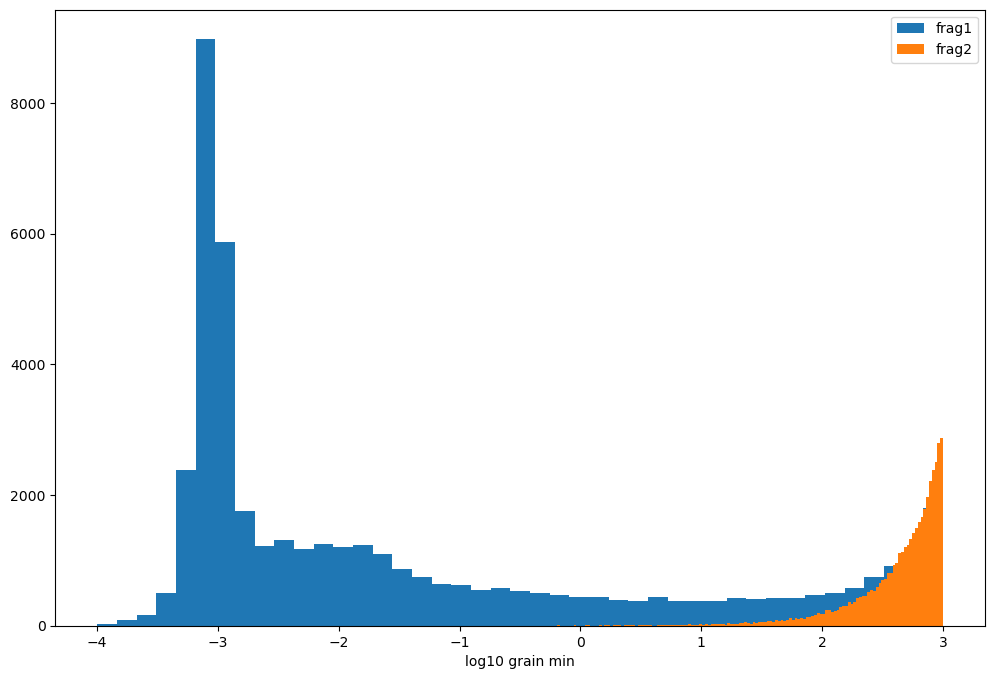

In [51]:
plt.figure(figsize = (12, 8))
plt.hist(np.log10(grain_mins[:, 0]), bins='auto', label = 'frag1')
plt.hist(np.log10(grain_mins[:, 1]), bins='auto', label = 'frag2')
plt.xlabel('log10 grain min')
plt.legend()

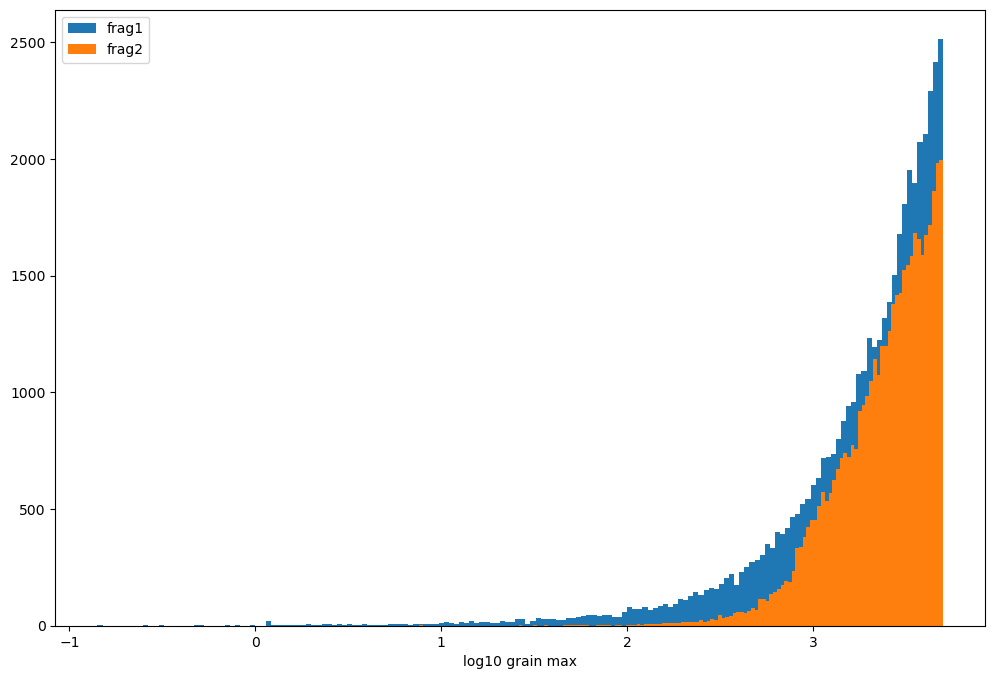

In [52]:
plt.figure(figsize = (12, 8))
plt.hist(np.log10(grain_maxs[:, 0]), bins='auto', label = 'frag1')
plt.hist(np.log10(grain_maxs[:, 1]), bins='auto', label = 'frag2')
plt.xlabel('log10 grain max')
plt.legend()

In [6]:
def flatten_list(nested_list):
    def flatten(lst):
        for item in lst:
            if isinstance(item, list):
                flatten(item)
            else:
                flat_list.append(item)

    flat_list = []
    flatten(nested_list)
    return flat_list

# helper function to unflatten the list
#### CHANGE THE NUMBER OF GLOBAL/FRAGMENT PARAMETERS TO TEST DIFFERENT COMBINATIONS
def unflatten_list_usg(lst, num_global_params=1, num_frag_params=5, er_frag_indices=ER_FRAG_INDICES):
    """
    change number of global parameters and frag parameters based on the structure of the free parameters object
    passed into the get_lc_cost_function() function
    """
    # print(lst[:num_global_params], list(zip(*[iter(lst[num_global_params:])]*(len(lst[num_global_params:])//num_frag_params))))
    num_frag_params = max(1, num_frag_params)
    sizes = list(np.repeat('k', num_frag_params - 1))
    sizes.insert(0, int(num_global_params))
    sizes.insert(2, int(len(er_frag_indices)))  # CHANGE THESE INDICES IF STRUCTURE CHANGES
    k = (len(lst) - sum(s for s in sizes if s != 'k')) // sizes.count('k') if 'k' in sizes else 0
    result, index = [], 0
    for size in sizes:
        group_size = k if size == 'k' else size
        if group_size == 1:
            result.append(lst[index])
        else:
            result.append(lst[index:index + group_size])
        index += group_size
    return result

def unflatten_list_csv(lst, num_global_params=1, num_frag_params=5, er_frag_indices=ER_FRAG_INDICES):
    """
    change number of global parameters and frag parameters based on the structure of the free parameters object
    passed into the get_lc_cost_function() function
    """
    # print(lst[:num_global_params], list(zip(*[iter(lst[num_global_params:])]*(len(lst[num_global_params:])//num_frag_params))))
    num_frag_params = max(1, num_frag_params)
    sizes = list(np.repeat('k', num_frag_params - 3))  # CHANGE THIS IF STRUCTURE CHANGES
    sizes.insert(0, int(num_global_params))  # CHANGE THIS IF STRUCTURE CHANGES
    sizes[2:2] = [int(len(er_frag_indices))] * 3  # CHANGE THESE INDICES IF STRUCTURE CHANGES
    # print(sizes)
    k = (len(lst) - sum(s for s in sizes if s != 'k')) // sizes.count('k') if 'k' in sizes else 0
    result, index = [], 0
    for size in sizes:
        group_size = k if size == 'k' else size
        if group_size == 1:
            result.append(lst[index])
        else:
            result.append(lst[index:index + group_size])
        index += group_size
    return result

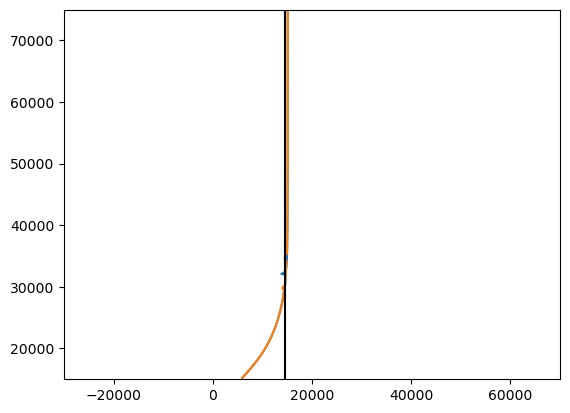

In [7]:
plt.plot(metsim_obj.simulation_results.leading_frag_vel_arr, metsim_obj.simulation_results.leading_frag_height_arr)
plt.plot(metsim_obj.simulation_results.brightest_vel_arr, metsim_obj.simulation_results.brightest_height_arr)
plt.xlim(-30000, 70000)
plt.ylim(15000,75000)
plt.axvline(np.mean(metsim_obj.simulation_results.main_vel_arr), color='k')

In [8]:
np.c_[metsim_obj.simulation_results.leading_frag_vel_arr, metsim_obj.simulation_results.leading_frag_height_arr].shape

(1269, 2)

Run MetSim and get all derived parameters using multiprocessing if haven't already:

In [9]:
# import signal

# class TimeoutException(Exception):
#     """Custom exception for timeouts."""
#     pass

# def timeout_handler(signum, frame):
#     raise TimeoutException("Function execution timed out")

# def get_derived_params(sample, metsim_obj=metsim_obj, timeout=20):
#     """
#     Gets the initial mass, mass percents and dynamic pressures of fragments, peak dynamic pressure, 
#     and mass remaining at peak dynamic pressure for a given sample and MetSim object:
#     """
#     if hasattr(metsim_obj, 'lc_data'):
#         free_params = unflatten_list_csv(list(sample))
#     else:
#         free_params = unflatten_list_usg(list(sample))
#     all_params = (free_params, metsim_obj.fixed_params)
    
#     # Set timeout handler
#     signal.signal(signal.SIGALRM, timeout_handler)
#     signal.alarm(timeout)  # Start the timer for timeout
#     # run simulation
#     try: 
#         metsim_obj.initializeSimulation(all_params)
#     except TimeoutException:
#         print('timeout')
#         return np.nan, np.array([np.nan for entry in metsim_obj.fragmentation_entries]).T, np.array([np.nan for entry in metsim_obj.fragmentation_entries]).T, np.nan, np.nan, np.nan, np.nan
#     finally:
#         signal.alarm(0)  # Cancel alarm
    
#     # # run simulation
#     # metsim_obj.initializeSimulation(all_params)
    
#     # Get the parameters:
#     # get initial mass
#     initial_mass = metsim_obj.const.m_init
#     # fragment mass percentages and dynamic pressures
#     mass_pcts, dyn_pressures = np.array([(np.float64(entry.mass)/initial_mass, entry.dyn_pressure) for entry in metsim_obj.fragmentation_entries]).T
#     # peak dynamic pressure and mass remaining at peak dynamic pressure
#     peak_dyn_pressure = np.nanmax(metsim_obj.simulation_results.leading_frag_dyn_press_arr)
#     peak_dyn_mass = metsim_obj.simulation_results.mass_total_active_arr[np.nanargmax(metsim_obj.simulation_results.leading_frag_dyn_press_arr)]/initial_mass
#     # leading and brightest velocity curves (m/s)
#     leading_vels = np.c_[metsim_obj.simulation_results.leading_frag_vel_arr, metsim_obj.simulation_results.leading_frag_height_arr]
#     brightest_vels = np.c_[metsim_obj.simulation_results.brightest_vel_arr, metsim_obj.simulation_results.brightest_height_arr]
#     # return all of them as tuple
#     return initial_mass, mass_pcts, dyn_pressures, peak_dyn_pressure, peak_dyn_mass, leading_vels, brightest_vels

# # run using multiprocessing:
# pool = multiprocessing.Pool(processes=multiprocessing.cpu_count() - 1)
# # run
# derived_params = list(tqdm(pool.imap(get_derived_params, samples), total = len(samples)))
# # join and close
# pool.close()
# pool.join()

# # save all the derived parameters
# initial_masses, peak_dyn_pressures, peak_dyn_masses = np.zeros((3, len(samples)))
# mass_pcts, dyn_pressures = np.zeros((2, len(samples), len(FREE_FRAG_INDICES)))
# leading_vels = []
# brightest_vels = []

# for i, sample in enumerate(derived_params):
#     initial_masses[i], mass_pcts[i], dyn_pressures[i], peak_dyn_pressures[i], peak_dyn_masses[i] = sample[0:5]
#     leading_vels.append(sample[5])
#     brightest_vels.append(sample[6])

# # save
# np.save(f'./derived_params/initial_masses_{event}', initial_masses)
# np.save(f'./derived_params/mass_pcts_{event}', mass_pcts)
# np.save(f'./derived_params/dyn_pressures_{event}', dyn_pressures)
# np.save(f'./derived_params/peak_dyn_pressures_{event}', peak_dyn_pressures)
# np.save(f'./derived_params/peak_dyn_masses_{event}', peak_dyn_masses)

Load saved derived parameters:

In [10]:
initial_masses = np.load(f'./derived_params/initial_masses_{event}.npy')
mass_pcts = np.load(f'./derived_params/mass_pcts_{event}.npy')
dyn_pressures = np.load(f'./derived_params/dyn_pressures_{event}.npy')
peak_dyn_pressures = np.load(f'./derived_params/peak_dyn_pressures_{event}.npy')
peak_dyn_masses = np.load(f'./derived_params/peak_dyn_masses_{event}.npy')

Plot and save:

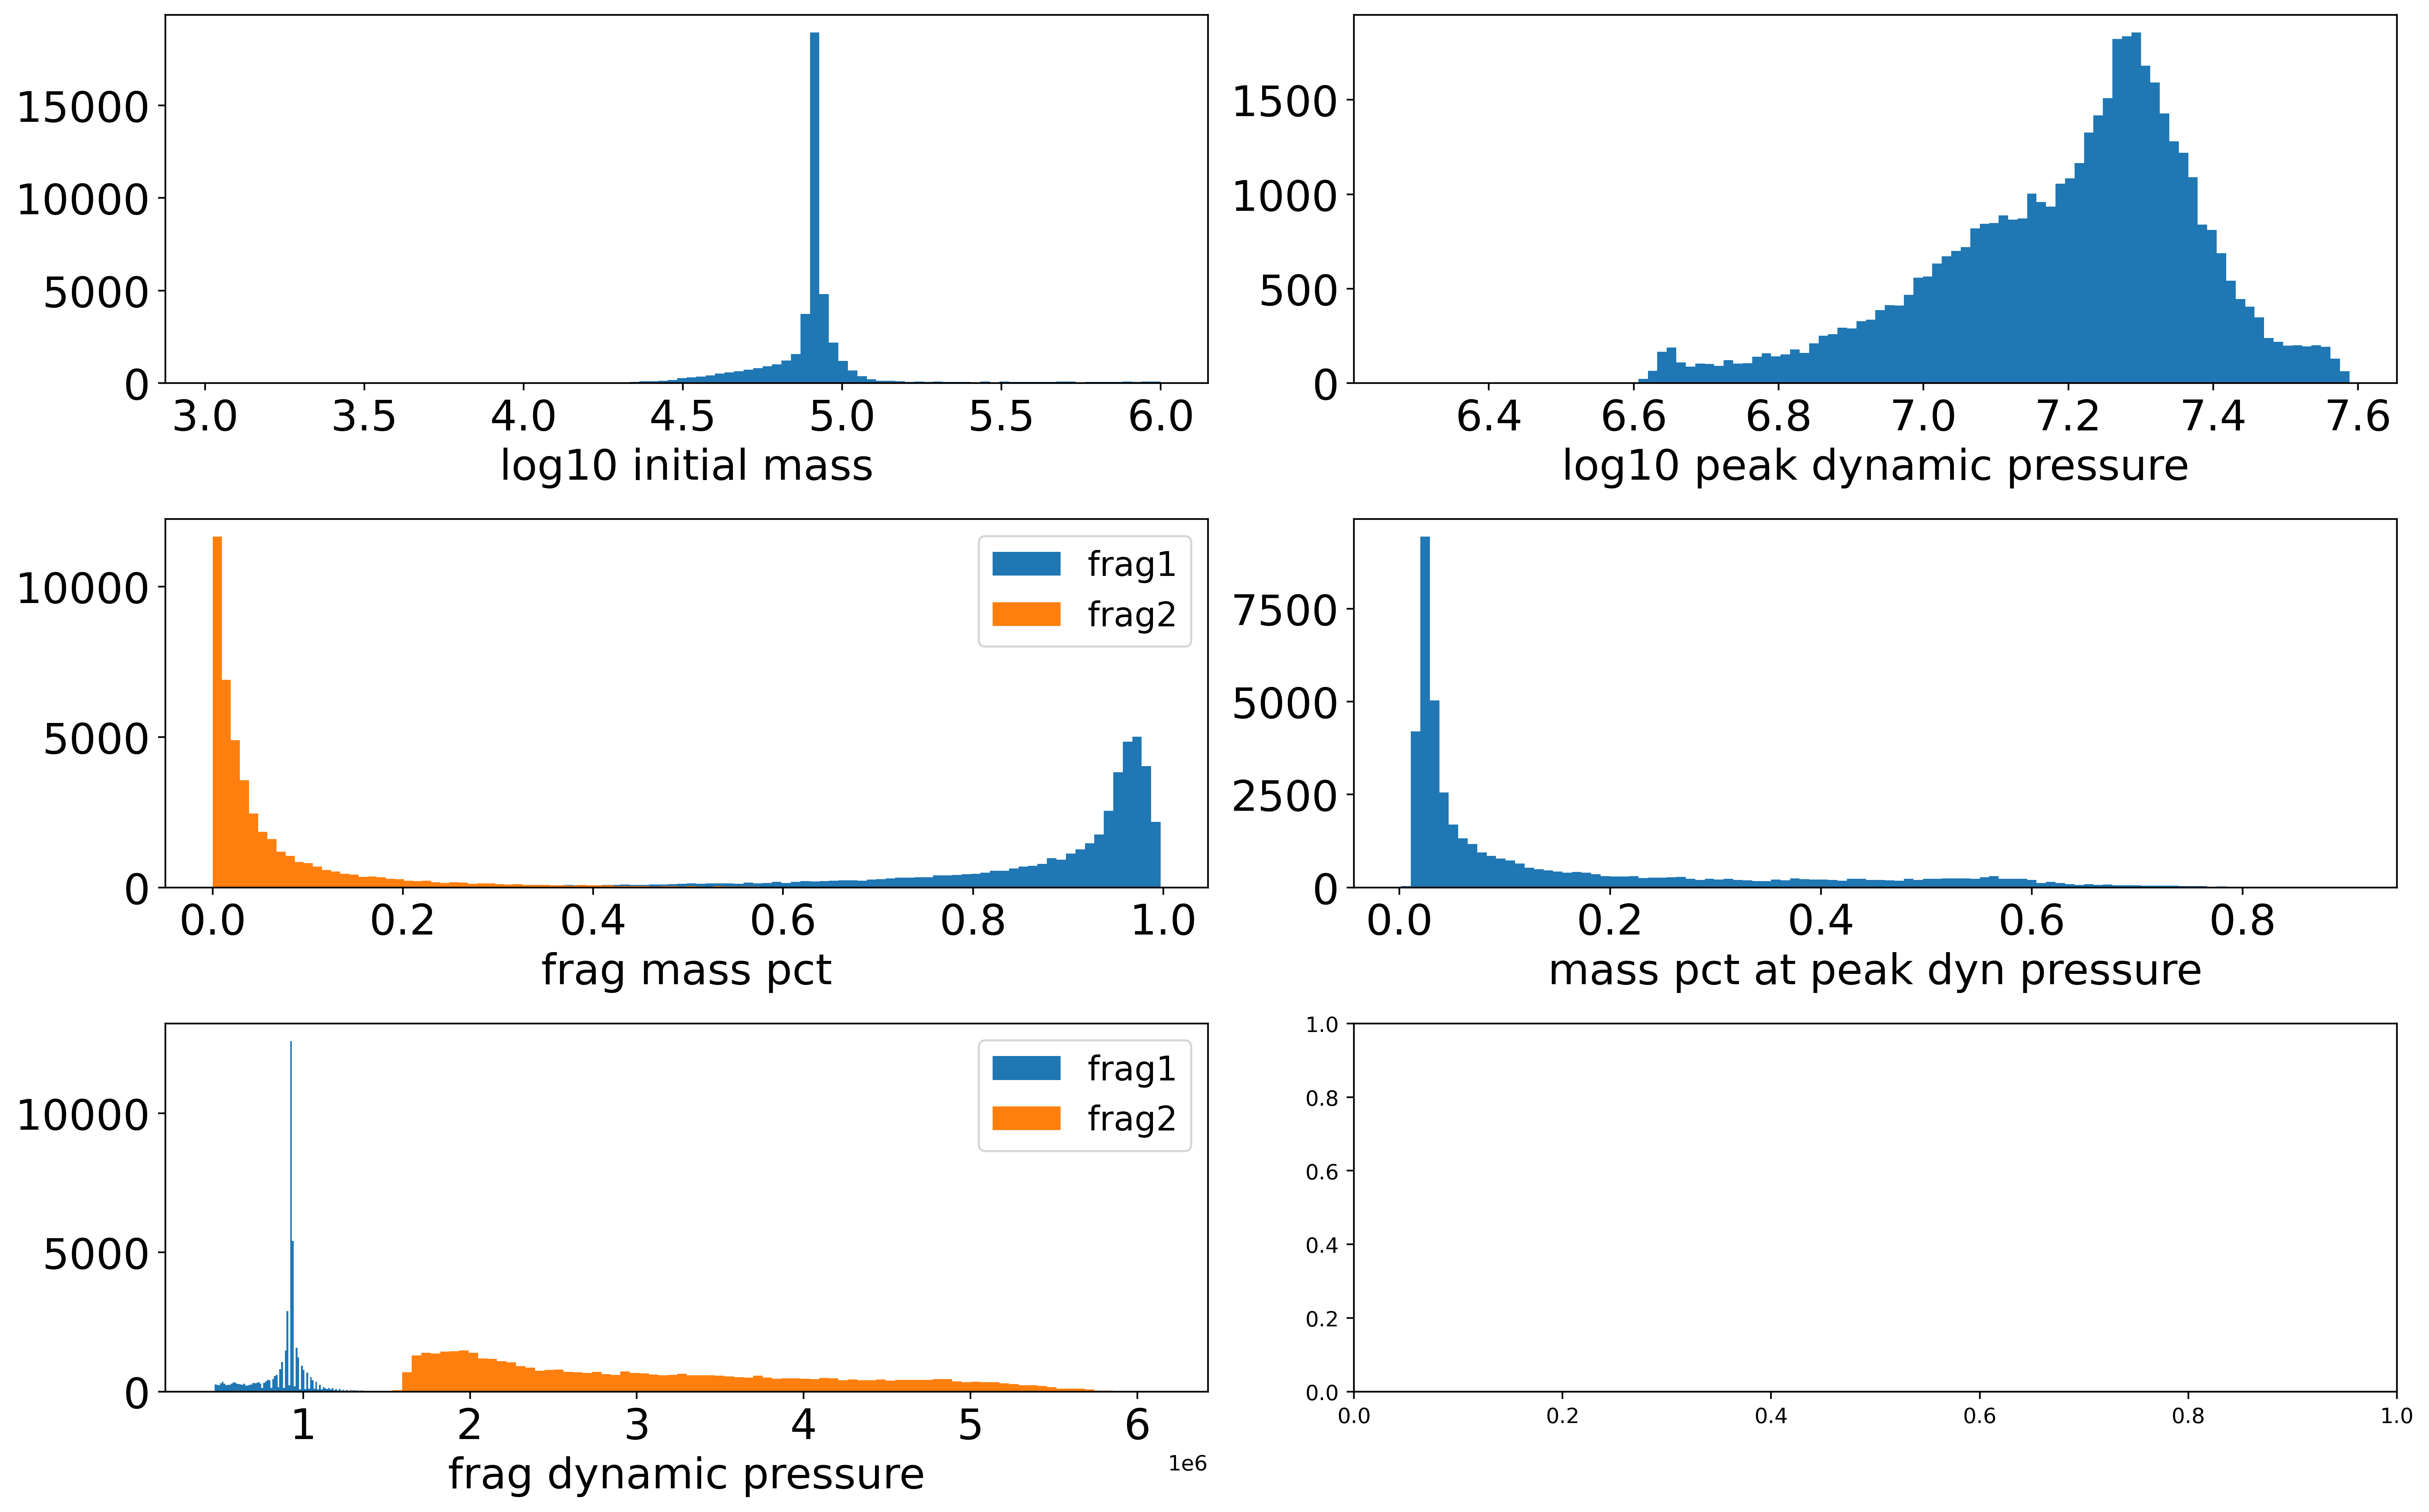

In [11]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize = (16, 10), dpi=400)
# plt.rc('font', size=20)
# plot initial mass
ax[0, 0].hist(np.log10(initial_masses), bins=100)
# ax[0, 0].set_xlim(1.e6, 4.e6)
ax[0, 0].set_xlabel('log10 initial mass', fontsize=20)
ax[0, 0].tick_params(axis='both', labelsize=20)
# fragment mass percentages and dynamic pressures
for i, frag in enumerate(mass_pcts.T):
    ax[1, 0].hist(frag, bins=100, label = f'frag{i + 1}', alpha=1.)
ax[1, 0].set_xlabel('frag mass pct', fontsize=20)
ax[1, 0].tick_params(axis='both', labelsize=20)
# fragment dynamic pressures
for i, frag in enumerate(dyn_pressures.T):
    ax[2, 0].hist(frag, bins=100, label = f'frag{i + 1}')
ax[2, 0].set_xlabel('frag dynamic pressure', fontsize=20)
ax[2, 0].tick_params(axis='both', labelsize=20)
# peak dynamic pressure
ax[0, 1].hist(np.log10(peak_dyn_pressures), bins='auto')
ax[0, 1].set_xlabel('log10 peak dynamic pressure', fontsize=20)
ax[0, 1].tick_params(axis='both', labelsize=20)
# mass at peak dynamic pressure
ax[1, 1].hist(peak_dyn_masses, bins=100)
ax[1, 1].set_xlabel('mass pct at peak dyn pressure', fontsize=20)
ax[1, 1].tick_params(axis='both', labelsize=20)
# legend
ax[1, 0].legend(loc='upper right', fontsize=16)
ax[2, 0].legend(loc='upper right', fontsize=16)
# make labels bigger
# tight layout
plt.tight_layout()
plt.savefig(f'./derived_params/derived_param_hists_{event}.png')

#### Novo Mesto:

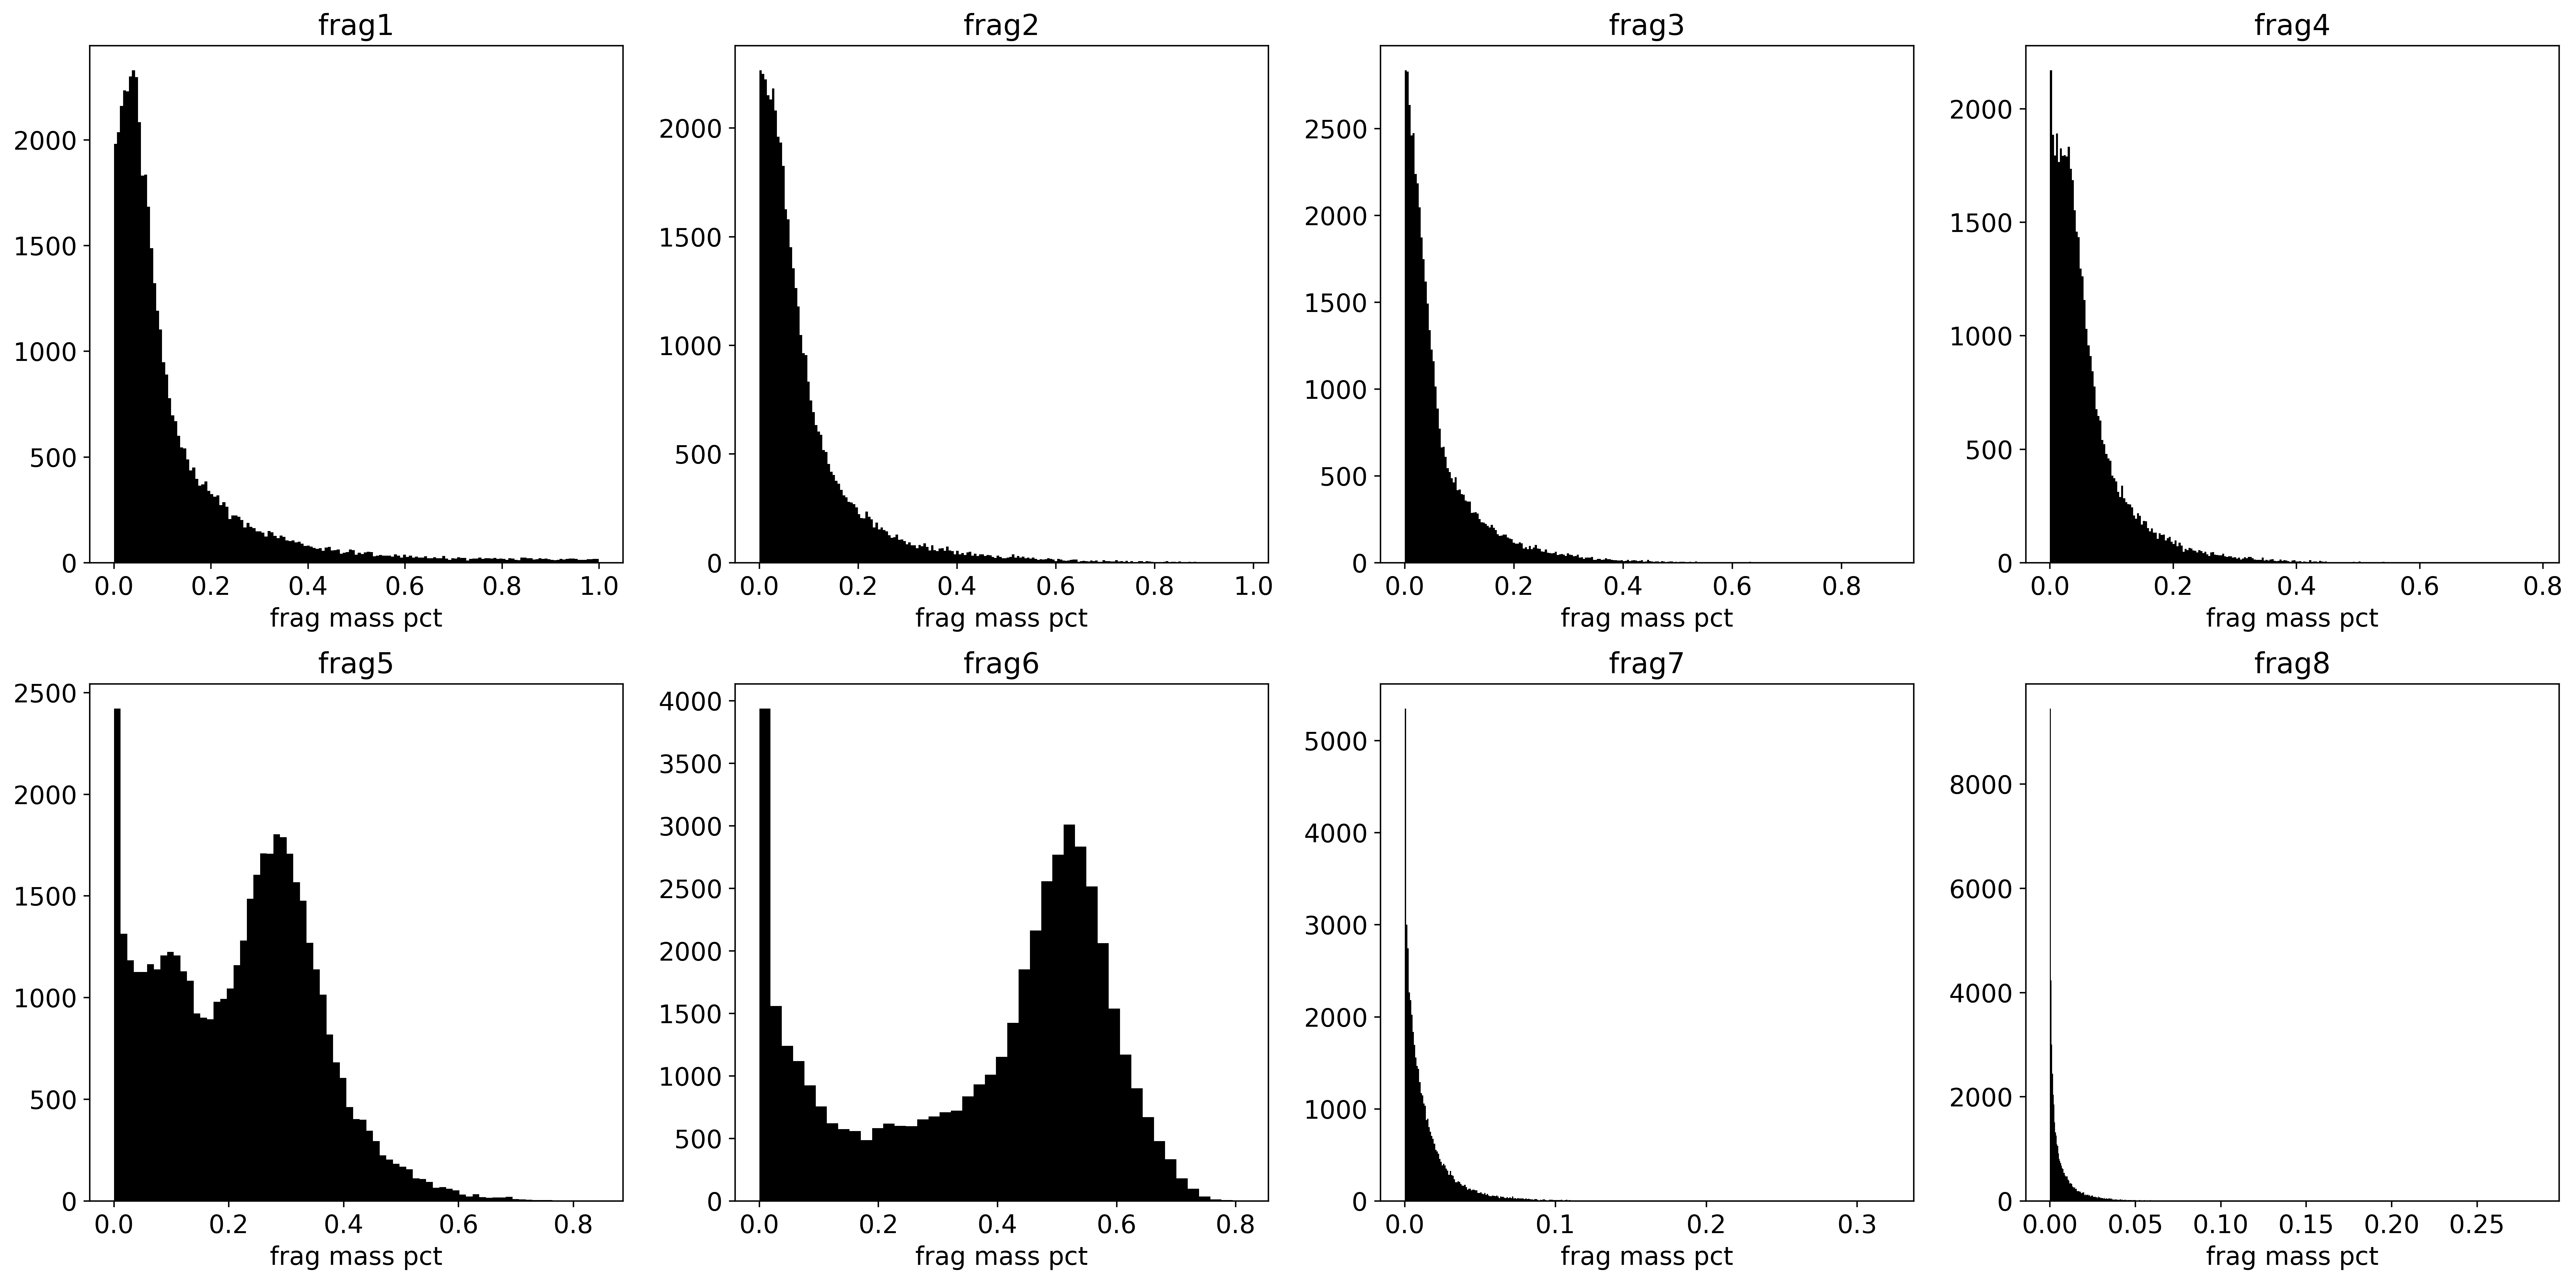

In [37]:
# fig, ax = plt.subplots(2, 4, figsize = (20, 10), dpi=400)
# for i, frag in enumerate(mass_pcts.T):
#     ax[i//4, i%4].hist(frag, bins='auto', color='k', label = f'frag{i+1}')
#     # ax[i//4, i%4].legend(fontsize=14)
#     ax[i//4, i%4].set_title(f'frag{i + 1}', fontsize=16)
#     ax[i//4, i%4].set_xlabel('frag mass pct', fontsize=14)
#     ax[i//4, i%4].tick_params(axis='both', labelsize=14)
# plt.tight_layout()
# plt.savefig(f'./derived_params/mass_pcts_novo_mesto.png')

Plot confidence regions for leading and brightest velocities:

In [225]:
# get all observed heights for which velocities have been measured
all_vel_heights = np.sort(np.concatenate([observation.model_ht[1:] for observation in metsim_obj.traj.observations]))
# get all leading velocities that are not nans and then interpolate at those heights
non_nan_leading_vhs = [vhs[:-1] for vhs in leading_vels if not isinstance(vhs, float)]  # all leading velocities and heights
non_nan_brightest_vhs = [vhs[:-1] for vhs in brightest_vels if not isinstance(vhs, float)]  # all leading velocities and heights
# interpolate and pack into array
interpolated_leading_vels = np.array([np.interp(all_vel_heights, np.flip(vhs[:, 1]), np.flip(vhs[:, 0])) for vhs in non_nan_leading_vhs])
interpolated_brightest_vels = np.array([np.interp(all_vel_heights, np.flip(vhs[:, 1]), np.flip(vhs[:, 0])) for vhs in non_nan_brightest_vhs])
# # optional: save/load
# np.save(f'./derived_params/interpolated_leading_vels_{event}.npy', interpolated_leading_vels)
# np.save(f'./derived_params/interpolated_brightest_vels_{event}.npy', interpolated_brightest_vels)
interpolated_leading_vels = np.load(f'./derived_params/interpolated_leading_vels_{event}.npy')
interpolated_brightest_vels = np.load(f'./derived_params/interpolated_brightest_vels_{event}.npy')

Compute quantiles: and plot as confidence regions:

In [226]:
# compute quantiles
leading_vel_quantiles = np.quantile(interpolated_leading_vels, [0.005, 0.025, 0.160, 0.840, 0.975, 0.995], axis=0)
brightest_vel_quantiles = np.quantile(interpolated_brightest_vels, [0.005, 0.025, 0.160, 0.840, 0.975, 0.995], axis=0)

Plot CRs:

(-10000.0, 50000.0)

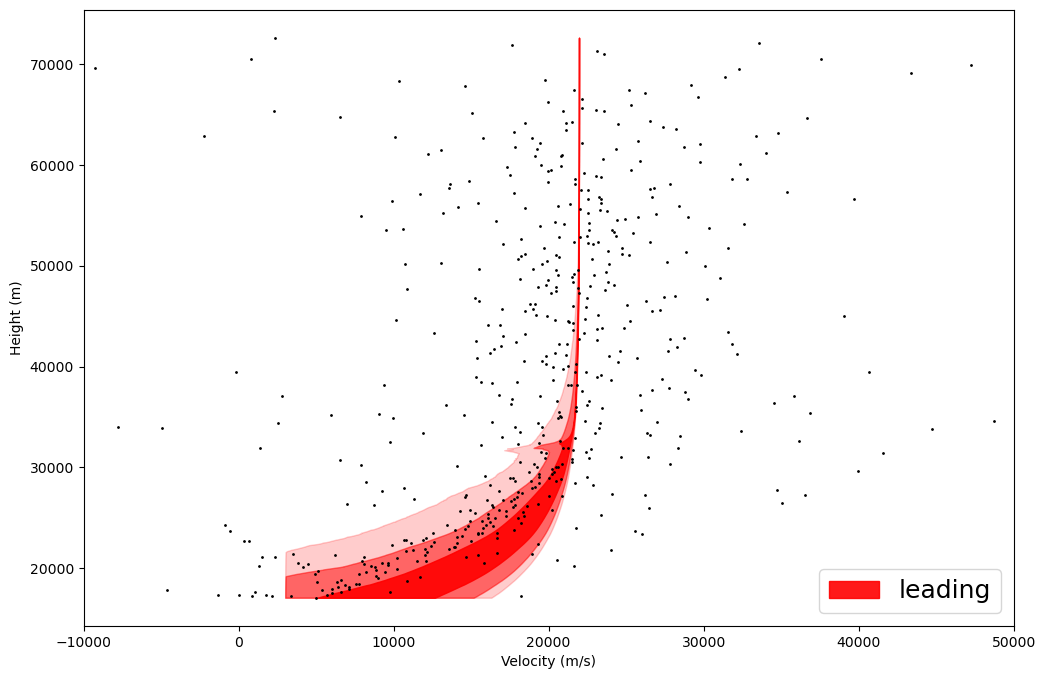

In [227]:
# plot the 1, 2, 3 sigma contours
plt.figure(figsize = (12, 8))
# 1, 2, 3 sigma contours
# leading
plt.fill_betweenx(all_vel_heights, leading_vel_quantiles[0], leading_vel_quantiles[-1], color='red', alpha=0.2) # 3 sigma
plt.fill_betweenx(all_vel_heights, leading_vel_quantiles[1], leading_vel_quantiles[-2], color='red', alpha=0.5) # 2 sigma
plt.fill_betweenx(all_vel_heights, leading_vel_quantiles[2], leading_vel_quantiles[-3], color='red', alpha=0.9, label = 'leading') # 1 sigma
# observed velocities
for observation in metsim_obj.traj.observations:
    plt.scatter(observation.velocities[1:], observation.model_ht[1:], color='k', s=1)
# best fit
# label
plt.xlabel('Velocity (m/s)'), plt.ylabel('Height (m)'), plt.legend(fontsize=18)
plt.xlim(-10000., 50000.)

(-10000.0, 50000.0)

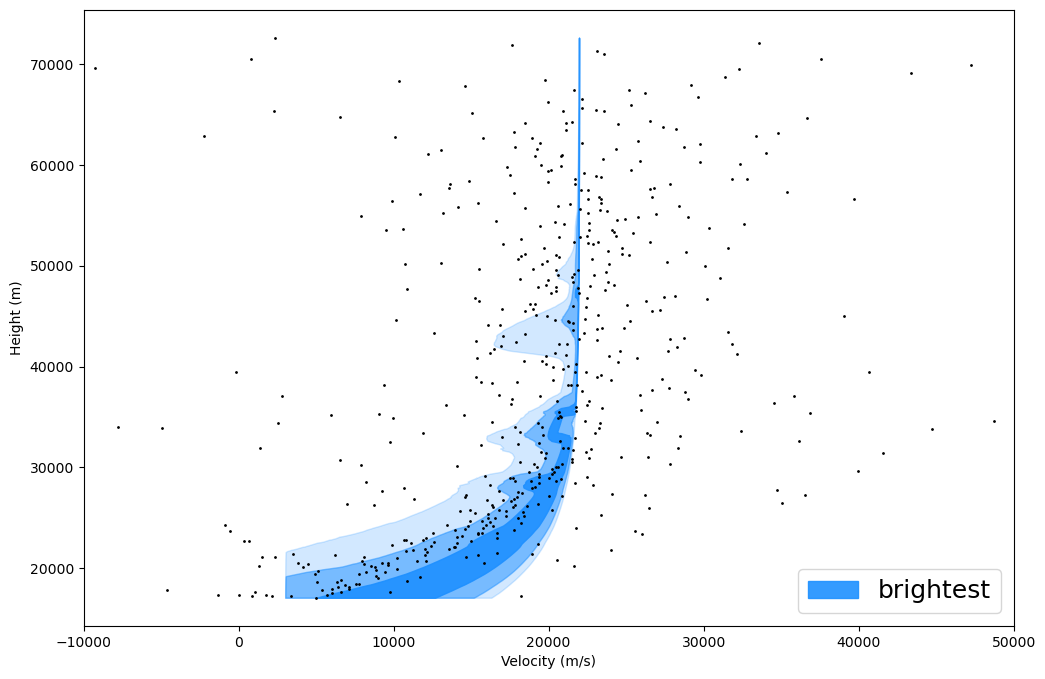

In [228]:
# plot the 1, 2, 3 sigma contours
plt.figure(figsize = (12, 8))
# 1, 2, 3 sigma contours
# brightest
plt.fill_betweenx(all_vel_heights, brightest_vel_quantiles[0], brightest_vel_quantiles[-1], color='dodgerblue', alpha=0.2) # 3 sigma
plt.fill_betweenx(all_vel_heights, brightest_vel_quantiles[1], brightest_vel_quantiles[-2], color='dodgerblue', alpha=0.5) # 2 sigma
plt.fill_betweenx(all_vel_heights, brightest_vel_quantiles[2], brightest_vel_quantiles[-3], color='dodgerblue', alpha=0.9, label = 'brightest') # 1 sigma
# observed velocities and best fit
for observation in metsim_obj.traj.observations:
    plt.scatter(observation.velocities[1:], observation.model_ht[1:], color='k', s=1)
# best fit
plt.xlabel('Velocity (m/s)'), plt.ylabel('Height (m)'), plt.legend(fontsize=18)
plt.xlim(-10000., 50000.)

#### Testing:

In [ ]:
np.mean(initial_masses), np.median(initial_masses)

In [12]:
np.mean(peak_dyn_pressures), np.median(peak_dyn_pressures)

(14638659.37640018, 4883403.152849406)

In [13]:
np.mean(peak_dyn_masses), np.median(peak_dyn_masses)

(30410.843328271425, 413.2479736275125)

In [14]:
event = event_path.rsplit('/')[2]

initial_masses = np.load(f'./derived_params/initial_masses_{event}.npy')
mass_pcts = np.load(f'./derived_params/mass_pcts_{event}.npy')
dyn_pressures = np.load(f'./derived_params/dyn_pressures_{event}.npy')
peak_dyn_pressures = np.load(f'./derived_params/peak_dyn_pressures_{event}.npy')
peak_dyn_masses = np.load(f'./derived_params/peak_dyn_masses_{event}.npy')

In [15]:
np.mean(initial_masses), np.median(initial_masses)

(2433006.3510087514, 2311431.626225291)

In [16]:
np.mean(peak_dyn_pressures), np.median(peak_dyn_pressures)

(34369986.25620599, 31068022.776032448)

In [17]:
np.mean(peak_dyn_masses), np.median(peak_dyn_masses)

(94892.79087310995, 28195.365243492233)